In [21]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
path_anoms = "/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ERA5/z_anoms_rolling_filtered.nc"
anoms = xr.open_dataset(path_anoms).__xarray_dataarray_variable__
anoms = anoms.to_dataset(name='Z_anoms')
anoms = anoms.Z_anoms.compute()

In [3]:
# anoms = anoms.sel(time=slice(None, '2014-12-31'))

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [5]:
list_regions = [[180, 330, 20, 80],
                [190, 320, 20, 80],
                [200, 310, 20, 80],
                [180, 310, 20, 80],
                [160, 310, 20, 80],
                [120, 310, 20, 80],
                [180, 330, 20, 90],
                [160, 330, 20, 80],
                [160, 330, 20, 90],
                [140, 330, 20, 80],
                [100, 360, 20, 80],
                [100, 20, 20, 80],
                [140, 330, 20, 90],
                [100, 360, 20, 90],
                [100, 20, 20, 90],
                [100, 40, 20, 90],
                [80, 60, 20, 90],
                [80, 79, 20, 90],
                [140, 330, 20, 80],
                [100, 360, 20, 80],
                [100, 20, 20, 80],
                [100, 40, 20, 80],
                [80, 60, 20, 80],
                [80, 79, 20, 80],
                [180, 330, 30, 80],
                [190, 320, 30, 80],
                [200, 310, 30, 80],
                [180, 310, 30, 80],
                [160, 310, 30, 80],
                [120, 310, 30, 80],
                [180, 330, 30, 90],
                [160, 330, 30, 80],
                [160, 330, 30, 90],
                [140, 330, 30, 80],
                [100, 360, 30, 80],
                [100, 20, 30, 80],
                [140, 330, 30, 90],
                [100, 360, 30, 90],
                [100, 20, 30, 90],
                [100, 40, 30, 90],
                [80, 60, 30, 90],
                [80, 79, 30, 90],
                [140, 330, 30, 80],
                [100, 360, 30, 80],
                [100, 20, 30, 80],
                [100, 40, 30, 80],
                [80, 60, 30, 80],
                [80, 79, 30, 80],
                [180, 330, 20, 70],
                [190, 320, 20, 70],
                [200, 310, 20, 70],
                [180, 310, 20, 70],
                [160, 310, 20, 70],
                [120, 310, 20, 70],
                [160, 330, 20, 70],
                [140, 330, 20, 70],
                [100, 360, 20, 70],
                [100, 20, 20, 70],
                [140, 330, 20, 70],
                [100, 360, 20, 70],
                [100, 20, 20, 70],
                [100, 40, 20, 70],
                [80, 60, 20, 70],
                [80, 79, 20, 70],
                [180, 330, 30, 70],
                [190, 320, 30, 70],
                [200, 310, 30, 70],
                [180, 310, 30, 70],
                [160, 310, 30, 70],
                [120, 310, 30, 70],
                [160, 330, 30, 70],
                [140, 330, 30, 70],
                [100, 360, 30, 70],
                [100, 20, 30, 70],
                [140, 330, 30, 70],
                [100, 360, 30, 70],
                [100, 20, 30, 70],
                [100, 40, 30, 70],
                [80, 60, 30, 70],
                [80, 79, 30, 70],
               ]

In [6]:
def iswithinregion(lon,lat,region):
    minlon,maxlon,minlat,maxlat = region

    if minlon<maxlon:
        if (lon<=maxlon)&(lon>=minlon)&(lat<=maxlat)&(lat>=minlat):
            return 1
        else:
            return 0
    elif minlon>maxlon:
        if (lon>maxlon)&(lon<minlon):
            return 0
        else:
            if (lat<=maxlat)&(lat>=minlat):
                return 1
            else:
                return 0
    

In [22]:
conds = []

for n_region in range(len(list_regions)):
    clusters_centers = np.load(f'../ResultsSensitivity/Centroids/Centroids_{str(n_region).zfill(3)}.npy')
    labels = np.load(f'../ResultsSensitivity/WRsTimeSeries/Labels_{str(n_region).zfill(3)}.npy')
    distances = np.load(f'../ResultsSensitivity/Distances/Distances_{str(n_region).zfill(3)}.npy')
    dbis = np.load(f'../ResultsSensitivity/DBI/DBI_{str(n_region).zfill(3)}.npy')
    maxcorrs = np.load(f'../ResultsSensitivity/Corrs/Corrs_{str(n_region).zfill(3)}.npy')

    path_maps = "../ResultsSensitivity/MapsCentroids/"
    avgs = xr.open_dataset(f'{path_maps}MapsCentroids_{str(n_region).zfill(3)}.nc')
    region = list_regions[n_region]

    # FILTER BY CONDITIONS
    
    ## 1. N of WRs <=5 (interpretability)
    
    if len(avgs.cluster)==5:
        cond1 = 1
    else:
        cond1 = 0
    
    ## 2. magnitude of anomalies >= 0.7 standard deviation within the domain
    
    limit_stds = 0.7
    max_anoms = []
    for cluster in avgs.cluster:
        max_anoms.append(abs(avgs.sel(cluster=cluster).Z_anoms).max().values[()]) 
    max_anoms = np.array(max_anoms)
    if len(max_anoms[max_anoms>=limit_stds])==len(avgs.cluster):
        cond2 = 1
    else:
        cond2 = 0
    
    ## 3. All max anomalies within region
    arewithin = []
    for cluster in avgs.cluster:
        where_max = np.where(abs(avgs.isel(cluster=cluster).Z_anoms)==max_anoms[cluster])
        
        lat_temp = avgs.isel(lat=where_max[0],lon=where_max[1]).sel(cluster=cluster).Z_anoms.lat.values[0]
        lon_temp = avgs.isel(lat=where_max[0],lon=where_max[1]).sel(cluster=cluster).Z_anoms.lon.values[0]
        arewithin.append(iswithinregion(lon_temp,lat_temp,region))
    arewithin = np.array(arewithin)
    if len(arewithin[arewithin==1])==len(avgs.cluster):
        cond3 = 1
    else:
        cond3 = 0
    
    ## 4. Persistence of WRs >= 10 days
    
    # Step 1: Identify consecutive runs
    # Find where the labels change
    change_points = np.diff(labels) != 0
    # Create a run-length array by grouping consecutive runs
    run_lengths = np.diff(np.where(np.concatenate(([True], change_points, [True])))[0])
    # Identify the corresponding labels for these runs
    run_labels = labels[np.concatenate(([0], np.where(change_points)[0] + 1))]
    # Create a DataFrame to easily handle grouping and averaging
    df = pd.DataFrame({'label': run_labels, 'length': run_lengths})
    # Step 2: Calculate the average persistence for each class
    average_persistence = df.groupby('label')['length'].mean()
    average_persistence = average_persistence.values
    
    if len(average_persistence[average_persistence>=5])==len(avgs.cluster):
        cond4 = 1
    else:
        cond4 = 0

    conds.append([cond1,cond2,cond3,cond4])

In [23]:
conds = np.array(conds)

In [26]:
conds.sum(axis=1)#.argmax()

array([2, 3, 4, 4, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3,
       2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 3, 2, 2, 2, 1, 2, 3, 1,
       2, 1, 2, 4, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 4,
       4, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3])

In [27]:
conds.sum(axis=0)

array([27, 23, 74, 79])

In [28]:
np.where(conds.sum(axis=1)==4)

(array([ 2,  3, 47, 65, 66]),)

FINAL REGION = [200, 310, 20, 80]

In [30]:
list_regions[2]

[200, 310, 20, 80]

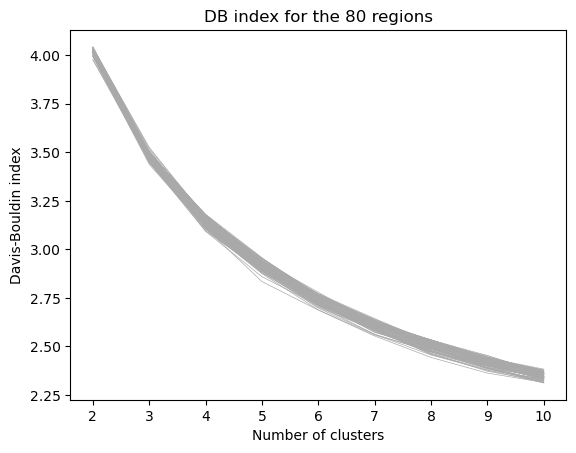

In [23]:
for n_region in range(len(list_regions)):
    # clusters_centers = np.load(f'../ResultsSensitivity/Centroids/Centroids_{str(n_region).zfill(3)}.npy')
    # labels = np.load(f'../ResultsSensitivity/WRsTimeSeries/Labels_{str(n_region).zfill(3)}.npy')
    # distances = np.load(f'../ResultsSensitivity/Distances/Distances_{str(n_region).zfill(3)}.npy')
    dbis = np.load(f'../ResultsSensitivity/DBI/DBI_{str(n_region).zfill(3)}.npy')
    plt.plot(np.arange(2,11),dbis,color='darkgray',lw=0.5)
    # maxcorrs = np.load(f'../ResultsSensitivity/Corrs/Corrs_{str(n_region).zfill(3)}.npy')
    # path_maps = "../ResultsSensitivity/MapsCentroids/"
    # avgs = xr.open_dataset(f'{path_maps}MapsCentroids_{str(n_region).zfill(3)}.nc')
    # region = list_regions[n_region]

plt.xlabel('Number of clusters')
plt.ylabel('Davis-Bouldin index')
plt.title('DB index for the 80 regions')
plt.savefig('../ResultsSensitivity/DBI.png',bbox_inches='tight')

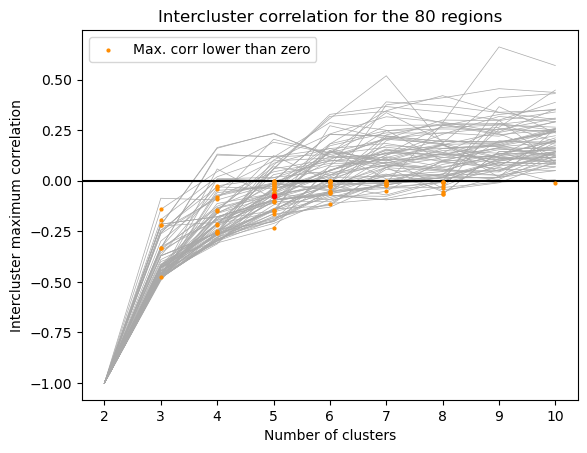

In [24]:
for n_region in range(len(list_regions)):
    maxcorrs = np.load(f'../ResultsSensitivity/Corrs/Corrs_{str(n_region).zfill(3)}.npy')
    plt.plot(np.arange(2,11),maxcorrs,color='darkgray',lw=0.5)
for n_region in range(len(list_regions)):
    maxcorrs = np.load(f'../ResultsSensitivity/Corrs/Corrs_{str(n_region).zfill(3)}.npy')
    maxcorrsneg = copy.deepcopy(maxcorrs)
    maxcorrsneg[maxcorrsneg>=0] = np.nan
    wheremax = np.nanargmax(maxcorrsneg)
    plt.scatter([np.arange(2,11)[wheremax]],[maxcorrsneg[wheremax]],color='darkorange',zorder=10,s=4)
    if n_region ==0:
        plt.scatter([np.arange(2,11)[wheremax]],[maxcorrsneg[wheremax]],color='darkorange',zorder=10,s=4,label = 'Max. corr lower than zero')
    if n_region==2:
        plt.scatter([np.arange(2,11)[wheremax]],[maxcorrsneg[wheremax]],color='red',zorder=11,s=10)

plt.legend()
plt.axhline(0,color='k')
plt.xlabel('Number of clusters')
plt.ylabel('Intercluster maximum correlation')
plt.title('Intercluster correlation for the 80 regions')
plt.savefig('../ResultsSensitivity/Corr.png',bbox_inches='tight')

In [21]:
maxcorrsneg = copy.deepcopy(maxcorrs)
maxcorrsneg[maxcorrsneg>=0] = np.nan
wheremax = np.nanargmax(maxcorrsneg)

In [22]:
wheremax

6

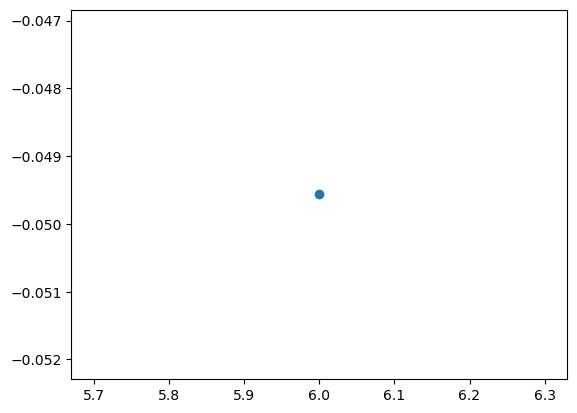

In [18]:
plt.scatter([np.arange(2,11)[wheremax]],[maxcorrsneg[wheremax]])

In [8]:
def compute_clusters_region(n_region):
    region = list_regions[n_region]
    data_region = extract_region(anoms, region)
    clusters_centers, labels, distances, dbis, maxcorrs, variance_explained = compute_wrs(data_region)
    
    freqs = []
    for label in np.unique(labels):
        freqs.append(100*len(labels[labels==label])/len(labels))
        
    nclusterslist = np.arange(2,11)    
    ## Compute K-means with best number of clusters
    maxcorrs_neg = np.array(maxcorrs)
    maxcorrs_neg[maxcorrs_neg>=0] = np.nan
    best_n_corr = nclusterslist[np.nanargmax(maxcorrs_neg)]
    best_n_dbi = nclusterslist[np.argmin(dbis)]

    centroids, avgs = get_average_fields_for_centroids(anoms, labels)

    ### Things to save
    np.save(f'../ResultsSensitivity/Centroids/Centroids_{str(n_region).zfill(3)}.npy', clusters_centers)
    np.save(f'../ResultsSensitivity/WRsTimeSeries/Labels_{str(n_region).zfill(3)}.npy', labels)
    np.save(f'../ResultsSensitivity/Distances/Distances_{str(n_region).zfill(3)}.npy', distances)
    np.save(f'../ResultsSensitivity/DBI/DBI_{str(n_region).zfill(3)}.npy', dbis)
    np.save(f'../ResultsSensitivity/Corrs/Corrs_{str(n_region).zfill(3)}.npy', maxcorrs)  

    path_maps = "../ResultsSensitivity/MapsCentroids/"
    xr.concat(avgs,dim='cluster').to_dataset(name='Z_anoms').to_netcdf(f'{path_maps}MapsCentroids_{str(n_region).zfill(3)}.nc')
    plot_multiple_maps(avgs,freqs,region,best_n_corr,best_n_dbi,variance_explained,
                      path_save=f'{path_maps}MapsCentroids_{str(n_region).zfill(3)}.png',save=True)
    

In [273]:
compute_clusters_region(45)

In [9]:
import multiprocessing
region_ids = np.arange(0,len(list_regions))
num_processes = 20
with multiprocessing.Pool(processes=num_processes) as pool:
        # Map the function to the pool
        results = pool.map(compute_clusters_region, region_ids)